# ⛈️ ⛈️ Bayesian Optimization Based Control of Stormwater Systems ⛈️ ⛈️

## Objective 
This notebook introduces a generalizable approach for controlling stormwater systems based on Bayesian Optimization. This notebook also demonstrates how users can use pystorms to evaluate the performance control algorithms across stormwater networks.


### Bayesian Optimization
In this notebook, we introduce an automated approach for controlling stormwater systems.
Bayesian Optimization is a sample-efficient approach for identifying the optima in hard or not easily solved problems using classical optimization frameworks.
Unlike Genetic Algorithms, which randomly explore the solution space, Bayesian Optimization identifies the optimum by efficiently exploring the solution space and learning a surrogate objective function.
Bayesian Optimization uses Gaussian Process to learn the surrogate objective function and samples the solution space in regions with the highest uncertainty in the objective function.
This approach reduces the number of samples(i.e., model runs) required for identifying an optimum. 
[Frazier (2018)](https://arxiv.org/abs/1807.02811) provides an excellent introduction to Bayesian Optimization.

*Example Illustration of Bayesian Optimization*

![bayesianOPT](./data/BaeOpt.gif)

### Control of stormwater systems using Bayesian Optimization

We can approach the control of stormwater systems as an optimization problem, where we identify the control actions that minimize an objective function. For example, the objective function can be the total flooding in the system or the total amount of loading at the treatment plant. 

$$ actions = arg\min Z(a) $$

In this notebook, we consider the scenario where we set one control action for the entire event. 

### Scenario Gamma

![Gamma](gamma_sheet.png)

In [ ]:
# Run this Google Colab to install packages 
!pip install GPyOpt pystorms 

In [1]:
import pystorms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization

In [23]:
# RC parms for pertty plots
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-dark-palette')

In [5]:
# Gamma Scenario for the basins in series
def GammaSimulationRun(actions, CTRL_ASSETS=4):

    # Initialize the scenario
    env = pystorms.scenarios.gamma()
    done = False
    
    # NOTE: You wouldnt have to update the datalog for the exercises
    # Modify the logger function to store depths
    env.data_log["depthN"] = {}
    for i in np.linspace(1, CTRL_ASSETS, CTRL_ASSETS, dtype=int):
        env.data_log["depthN"][str(i)] = []

    # Dont log the params from upstream, we donot care about them
    for i in np.linspace(CTRL_ASSETS + 1, 11, 11 - CTRL_ASSETS, dtype=int):
        del env.data_log["flow"]['O' + str(i)]
        del env.data_log["flooding"][str(i)]

    # Simulate controlled response
    while not done:
        done = env.step(actions)

    # Return the logged params
    return env.data_log

In [6]:
# Objective Function
def f_loss(x):
    # GypOpt uses 2d array
    # pystorms requies 1d array
    x = x.flatten()

    # Simulate the response of control actions
    data = GammaSimulationRun(x)

    # Convert to pandas dataframes
    depths = pd.DataFrame.from_dict(data["depthN"])
    flows = pd.DataFrame.from_dict(data["flow"])
    flooding = pd.DataFrame.from_dict(data["flooding"])

    # Compute loss - check the performance metric equation in Readme
    loss = 0.0

    # Flooding loss
    for node in flooding.keys():
        if flooding[node].sum() > 0.0:
            loss += 10 ** 4 * flooding[node].sum()

    # Flow deviation
    flows = flows.sub(4.0)
    flows[flows < 0.0] = 0.0
    loss += flows.sum().sum()

    # Prevent basins from storing water at the end.
    for i in depths.values[-1]:
        if i > 0.1:
            loss += i * 10 ** 3

    return loss

In [ ]:
# Read the parsed args
random_seed = 42
number_iter = 50

# Set the random seed
np.random.seed(random_seed)

# Create the domain
domain = []
for i in range(1, 5):
    domain.append({"name": "var_" + str(i), "type": "continuous", "domain": (0.0, 1.0)})


myBopt = BayesianOptimization(
    f=f_loss, domain=domain,
    model_type="GP",
    acquisition_type="EI",
)

myBopt.run_optimization(
    max_iter=number_iter,
    verbosity=True,
    eps=0.005,
)

In [11]:
optima = myBopt.x_opt
print("Optimial Control Actions :", optima)

Optimial Control Actions : [0.15601864 0.70807258 0.18182497 0.29122914]


In [12]:
# Evalute the controlled response
controlled_response = GammaSimulationRun(optima)
uncontrolled_response = GammaSimulationRun([1.0, 1.0, 1.0, 1.0])


 o  Retrieving project data
 o  Retrieving project data

Text(0.5, 1.0, 'Scenario Gamma: Controlled and Uncontrolled Response')

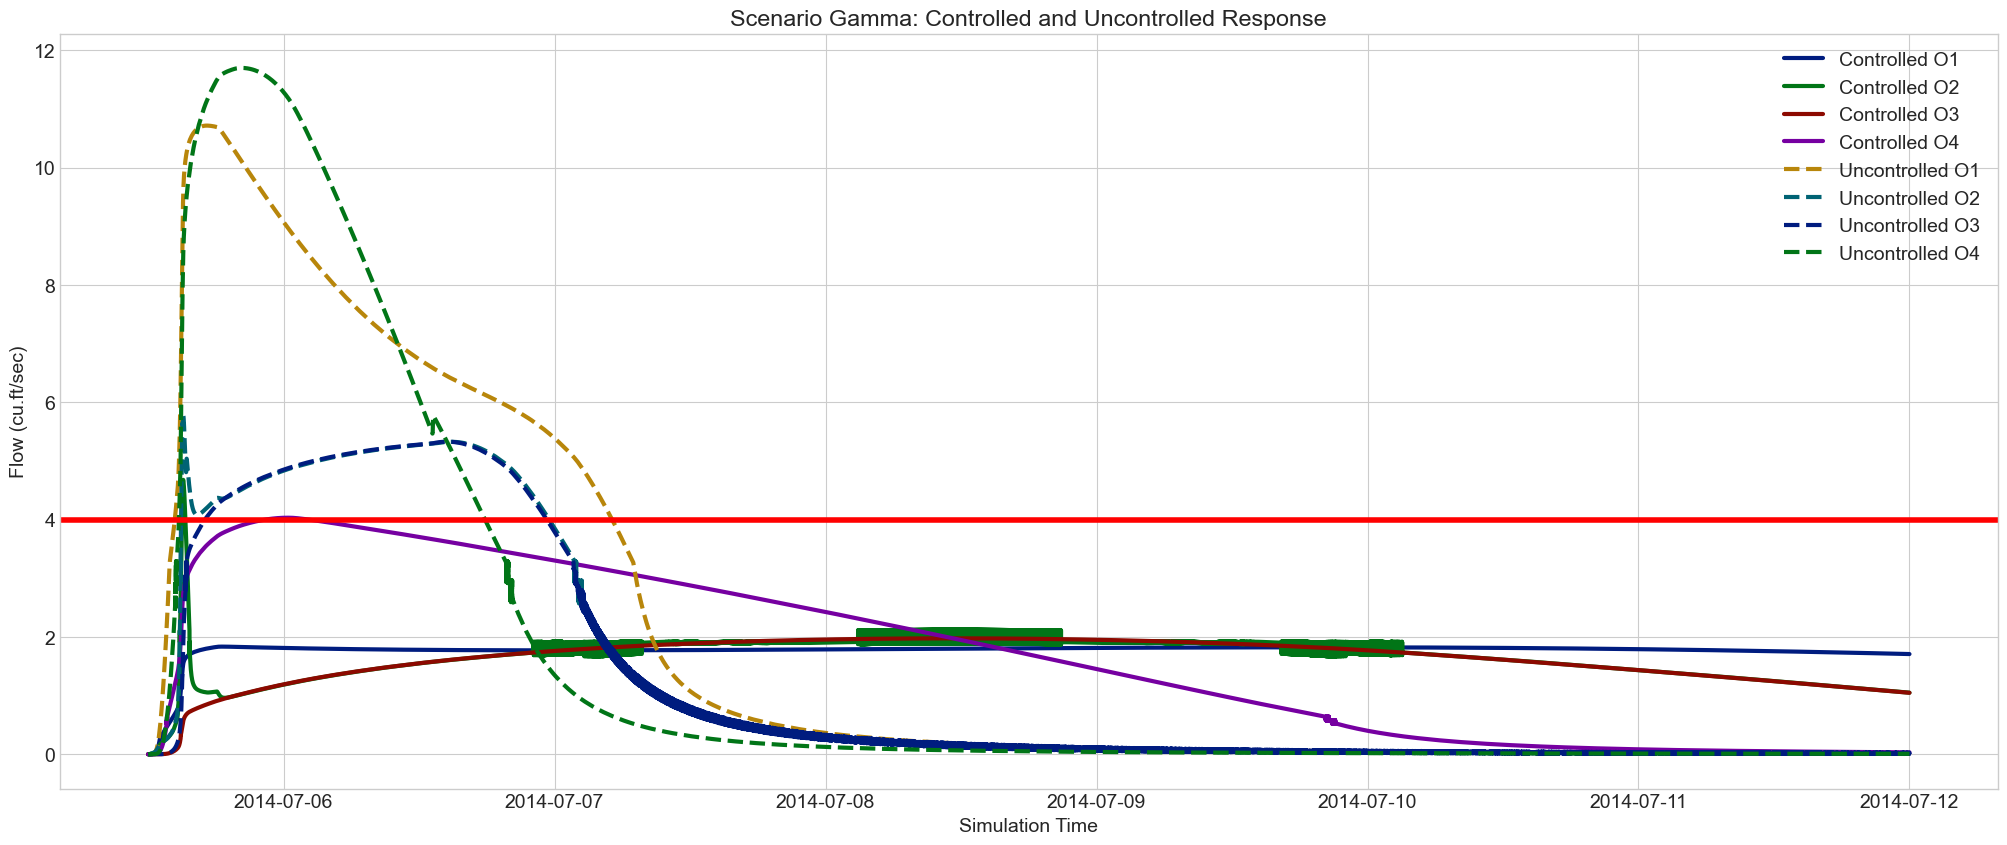

In [30]:
plt.figure(figsize=(25, 10), dpi=100)
for i in controlled_response['flow'].keys():
    plt.plot(controlled_response['simulation_time'], controlled_response['flow'][i], label= 'Controlled ' + i, linewidth=3.0)
for i in controlled_response['flow'].keys():
    plt.plot(uncontrolled_response['simulation_time'], uncontrolled_response['flow'][i], linestyle='--',label= 'Uncontrolled ' + i, linewidth=3.0)
plt.axhline(4.0, linewidth=4.0, color='red')
plt.legend()
plt.xlabel("Simulation Time")
plt.ylabel("Flow (cu.ft/sec)")
plt.title("Scenario Gamma: Controlled and Uncontrolled Response")

### Exercise 1
1. Update the `f_loss` function to use scenario gamma's peformance metric and identify the optimal gate position.
Hint: `env.performance()` gives the overall performance from a model run
2. Plot the flows in the controlled and uncontrolled scenarios.

### Exercise 2
Using the control strategy presented above, find the control actions that minimize the performance metric in scenario epsilon.

![epsilon](./data/epsilon.png)


```yaml
# Configuration file for scenario theta 

# name of scearnio 
name: epsilon
# binary 
binary: pollutant_support
# state definitions
states:
        - !!python/tuple 
          - "004"
          - depthN
        - !!python/tuple
          - "006"
          - depthN
        - !!python/tuple 
          - "011"
          - depthN
        - !!python/tuple
          - "022"
          - depthN
        - !!python/tuple 
          - "027"
          - depthN
        - !!python/tuple
          - "030"
          - depthN
        - !!python/tuple 
          - "033"
          - depthN
        - !!python/tuple
          - "039"
          - depthN
        - !!python/tuple 
          - "044"
          - depthN
        - !!python/tuple
          - "050"
          - depthN
        - !!python/tuple 
          - "060"
          - depthN
        - !!python/tuple
          - "001"
          - depthN
        - !!python/tuple
          - "001"
          - pollutantL
          - TSS

# Action space 
action_space:
        - "ISD001"
        - "ISD002"
        - "ISD003"
        - "ISD004"
        - "ISD005"
        - "ISD006"
        - "ISD007"
        - "ISD008"
        - "ISD009"
        - "ISD010"
        - "ISD011"  

# Performance Targets
performance_targets:
        - !!python/tuple
          - "001"
          - loading
        - !!python/tuple
          - "001"
          - flow
        - !!python/tuple
          - "004"
          - flooding
        - !!python/tuple
          - "006"
          - flooding
        - !!python/tuple
          - "011"
          - flooding
        - !!python/tuple
          - "022"
          - flooding
        - !!python/tuple
          - "027"
          - flooding
        - !!python/tuple
          - "030"
          - flooding
        - !!python/tuple
          - "033"
          - flooding
        - !!python/tuple
          - "039"
          - flooding
        - !!python/tuple
          - "044"
          - flooding
        - !!python/tuple
          - "050"
          - flooding
        - !!python/tuple
          - "060"
          - flooding
```